In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre, hermitenorm
from scipy.integrate import nquad, quad, dblquad
from itertools import product
from numba import njit

In [2]:
@njit
def function(Z1, Z2):
    """
    Calculate the value of the given function.

    Args:
        Z1 (float): First input parameter.
        Z2 (float): Second input parameter.

    Returns:
        float: The value of the mathematical function.
    """
    # adapted such that no coordinate transformation is necessary
    return -(Z1) * (Z2)**3 + np.exp(-0.5*(Z1)**2 - 0.1 * (Z2)**2)

def get_pairs(max_order, dims=2):
    """
    Generate pairs of integers where sum of each pair is less than or equal to max_order.

    Args:
        max_order (int): The maximum integer value for pairs.
        dims (int, optional): Number of dimensions for the pairs. Default is 2.

    Returns:
        list: List of pairs of integers.
    """
    pairs = []
    for pair in product(np.arange(0, max_order), repeat=dims):
        if sum(pair) <= max_order:
            pairs.append(pair)
    return pairs

@njit
def normal_pdf(x, mu=0, sigma=1):
    """
    Calculate the probability density function (PDF) of a normal (Gaussian) distribution.

    Args:
        x (float or ndarray): The value(s) at which to evaluate the PDF.
        mu (float, optional): The mean (average) of the normal distribution. Default is 0.
        sigma (float, optional): The standard deviation of the normal distribution. Default is 1.

    Returns:
        float or ndarray: The PDF value(s) at the specified input value(s).
    """
    return 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def integral_nominator(Z1, Z2, phi1, phi2):
    """
    Calculate the integrand for a specific pair of Legendre and Hermite polynomials.

    Args:
        Z1 (float): First input parameter.
        Z2 (float): Second input parameter.
        phi1 : Legendre polynomial
        phi2 : Hermite polynomials.

    Returns:
        float: The value of the integrand.
    """
    f = function(Z1, Z2) # calculate f with transformed variables
    return f * phi1(Z1) * phi2(Z2) * 0.5 * normal_pdf(Z2)

def inner_leg(z, order):
    """
    Calculate the inner product of a Legendre polynomial of a given order.

    Args:
        z (float): The input value at which to evaluate the Legendre polynomial.
        order (int): The order of the Legendre polynomial.

    Returns:
        float: The inner product value.
    """
    phi = legendre(order)
    return phi(z) * phi(z) * 0.5

def inner_her(z, order):
    """
    Calculate the inner product of a Hermite polynomial of a given order.

    Args:
        z (float): The input value at which to evaluate the Hermite polynomial.
        order (int): The order of the Hermite polynomial.

    Returns:
        float: The inner product value.
    """
    phi = hermitenorm(order) 
    return phi(z) * phi(z) * normal_pdf(z)

def get_coefficents(max_order, dims=2):
    """
    Calculate coefficients for the pairs of Legendre and Hermite polynomials.

    Args:
        max_order (int): The maximum order for Legendre and Hermite polynomials.
        dims (int, optional): Number of dimensions. Default is 2.

    Returns:
        tuple: A tuple containing pairs of Legendre and Hermite polynomials, and their coefficients.
    """
    pairs = get_pairs(max_order, dims)

    # Pre-calculate gamma's so we can reuse them
    gamma1s = []
    gamma2s = []
    for i in range(max_order+1):
            gamma1s.append(quad(inner_leg, -1, 1, args=i)[0])
            gamma2s.append(quad(inner_her, -np.inf, np.inf, args=i)[0])
            if i%10 == 0:
                print(i," of ",max_order+1," iterations")

    fhats = []
    for i, pair in enumerate(pairs):
        phi1 = legendre(pair[0])  # This line uses legendre, make sure it is imported or defined.
        phi2 = hermitenorm(pair[1])  # This line uses hermite, make sure it is imported or defined.
        nominator = nquad(integral_nominator, [[-1, 1], [-np.inf, np.inf]], args=[phi1, phi2])[0]
        fhats.append(nominator / (gamma1s[pair[0]] * gamma2s[pair[1]]))
        if i%100 == 0:
            print(i," of ",len(pairs)," iterations")

    return pairs, fhats

def proj_eval(z1, z2, pairs, fhats):
    """
    Evaluate the projection of the function onto a set of basis functions.

    Args:
        z1 (array-like): Input values for the first dimension.
        z2 (array-like): Input values for the second dimension.
        pairs (list): List of pairs representing Legendre and Hermite polynomial orders.
        fhats (list): List of coefficients for each pair.

    Returns:
        ndarray: The projection matrix.
    """
    proj = np.zeros((len(z1), len(z1)))
    for i, pair in enumerate(pairs):
        proj += fhats[i] * legendre(pair[0])(z1) * hermitenorm(pair[1])(z2)  # This line uses legendre and hermite, make sure they are imported or defined.

    return proj


In [3]:
X, Y = np.meshgrid(np.linspace(-1,1,1000), np.linspace(-3,3,1000))
Zf = function(X,Y)

In [4]:
np.mean(Zf)

0.6551523875256017

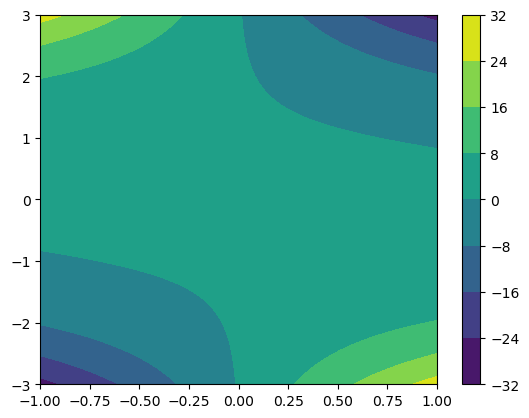

In [5]:
plt.contourf(X,Y,Zf)
plt.colorbar()

In [6]:
max_order = 20
pairs, fhats = get_coefficents(max_order)

0  of  21  iterations
10  of  21  iterations
20  of  21  iterations
0  of  229  iterations


/Users/nik/opt/miniconda3/envs/IntroCLS/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


100  of  229  iterations
200  of  229  iterations


In [7]:
# max_order = 100
# pairs = get_pairs(max_order)
# fhats = np.load('fhats_100.npy')

In [8]:
# np.save('fhats_20',fhats)

Zp = proj_eval(X,Y,pairs,fhats)

In [9]:
Zp

array([[-26.75340305, -26.69885531, -26.64430757, ...,  27.13947621,
         27.19303658,  27.24659695],
       [-26.59067597, -26.53645045, -26.48222493, ...,  26.97917939,
         27.03241398,  27.08564857],
       [-26.42859548, -26.37469087, -26.32078628, ...,  26.81952939,
         26.8724395 ,  26.9253496 ],
       ...,
       [ 26.9253496 ,  26.8724395 ,  26.81952939, ..., -26.32078628,
        -26.37469087, -26.42859548],
       [ 27.08564857,  27.03241398,  26.97917939, ..., -26.48222493,
        -26.53645045, -26.59067597],
       [ 27.24659695,  27.19303658,  27.13947621, ..., -26.64430757,
        -26.69885531, -26.75340305]])

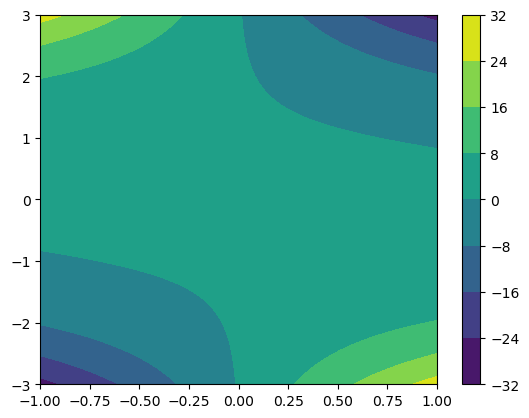

In [10]:
plt.contourf(X,Y,Zp)
plt.colorbar()

In [23]:
pZ = 1/2 * np.ones(Zf.shape)
pZ = np.multiply(normal_pdf(Y), pZ) /(len(X)*len(Y))
np.sum(pZ)

0.08302745124753654

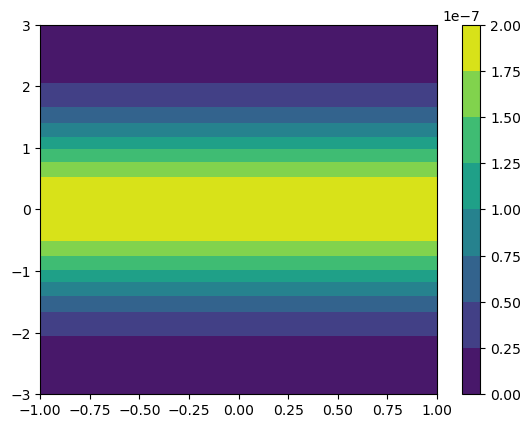

In [24]:
plt.contourf(X,Y,pZ)
plt.colorbar()

In [25]:
np.sum(normal_pdf(np.linspace(-10,10,1000)))

49.95000000000002

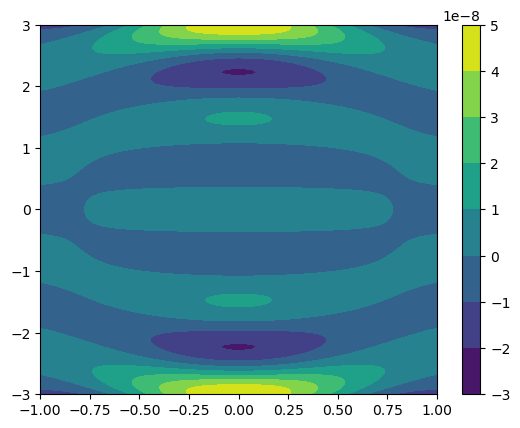

In [26]:
plt.contourf(X,Y,Zf-Zp)
plt.colorbar()

In [27]:
# use the calculated coesfficents to get the errors for lower orders
orders = np.arange(1,max_order)
terms = []
errors = []

for order in orders:
    ord_pairs = get_pairs(order)
    terms.append(len(ord_pairs))
    ord_fhats = []
    for i,pair in enumerate(pairs):
        if pair in ord_pairs:
            ord_fhats.append(fhats[i])
    
    Zp = proj_eval(X,Y,ord_pairs,ord_fhats)
    wE = np.linalg.norm((Zf-Zp)*pZ,2) # np.sqrt(np.sum(((Zf-Zp)*pZ)**2))
    errors.append(np.sum(wE))

In [28]:
len(errors)

19

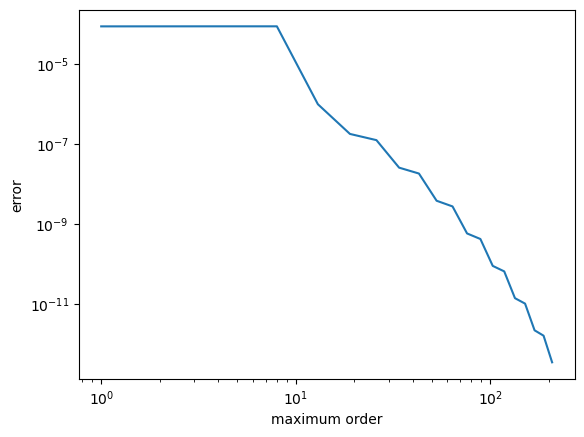

In [29]:
plt.plot(terms, errors)
plt.xlabel("maximum order")
plt.ylabel("error")
plt.yscale("log")
plt.xscale("log")

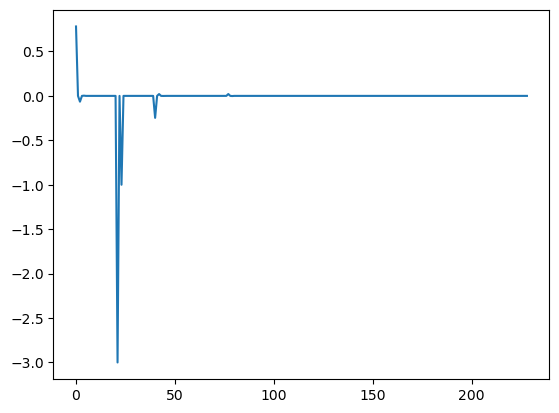

In [18]:
plt.plot(fhats)

In [19]:
fhats

[0.7810746336516176,
 0.0,
 -0.0650895528043013,
 0.0,
 0.002712064700179222,
 0.0,
 -7.533513056054048e-05,
 0.0,
 1.5694818866779676e-06,
 0.0,
 -2.615803144461096e-08,
 0.0,
 3.6330599228545437e-10,
 0.0,
 -4.325071336678548e-12,
 0.0,
 4.505282642520195e-14,
 0.0,
 -4.171558002935833e-16,
 0.0,
 0.0,
 -3.0000000000000018,
 0.0,
 -1.0,
 0.0,
 -1.3877787807814457e-17,
 0.0,
 -1.0573552615477677e-18,
 0.0,
 -5.580486102613222e-19,
 0.0,
 6.408213706350109e-20,
 0.0,
 0.0,
 0.0,
 -5.007639526329755e-23,
 0.0,
 4.909450516009564e-24,
 0.0,
 3.904592223259069e-25,
 -0.2472583835306545,
 6.491968233550786e-17,
 0.020604865294222105,
 1.5093998626006122e-17,
 -0.0008585360539258741,
 2.276180956587921e-18,
 2.3848223720164298e-05,
 -7.87966737866576e-21,
 -4.968379941656123e-07,
 -7.512200995283483e-21,
 8.280633236166315e-09,
 3.2106115985293764e-21,
 -1.1500879494726488e-10,
 5.0219291242566625e-22,
 1.3691523207865974e-12,
 -4.408491889207893e-25,
 -1.426200334380678e-14,
 2.40133829766

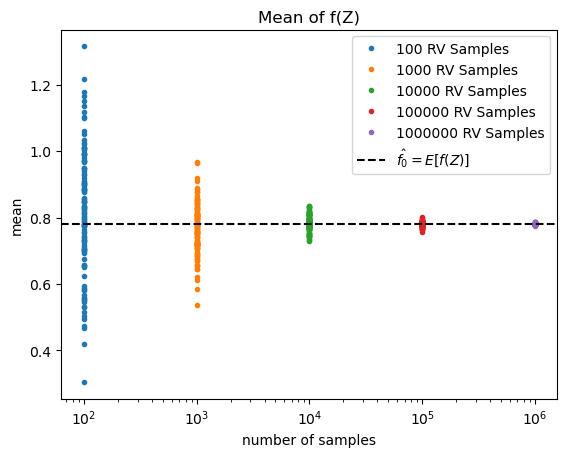

In [20]:
samples = [100, 1000, 10000, 100000, 1000000]
sample_mean = {}
sample_var = {}
for num in samples:
    mean = []
    var = []
    for _ in range(120):
        Z1 = np.random.uniform(-1, 1,num)
        Z2 = np.random.normal(0,1,num)
        mean_MC = np.mean(function(Z1, Z2))
        var_MC = np.var(function(Z1, Z2))
        mean.append(mean_MC)
        var.append(var_MC)
    sample_mean[num] = mean
    sample_var[num] = var

    plt.semilogx([num] * len(sample_mean[num]), sample_mean[num], '.', label=f"{num} RV Samples")

plt.axhline(fhats[0], color='black', linestyle='--', label=r'$\hat{f_0}=E[f(Z)]$')
plt.title("Mean of f(Z)")
plt.xlabel("number of samples")
plt.ylabel("mean")
plt.legend()
plt.show()

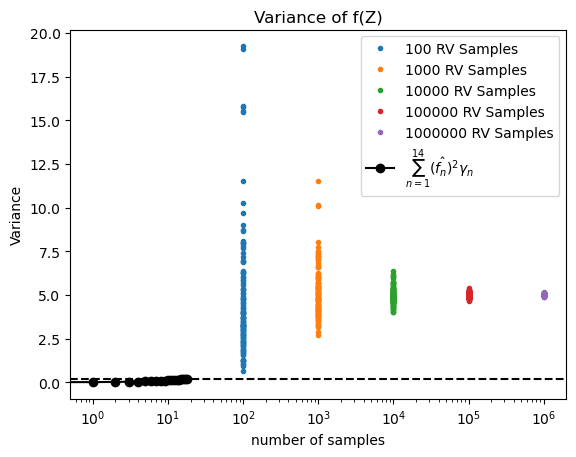

In [39]:
var_analytic = []
var = 0
for i in range(max_order-1):
    pairs = get_pairs(i+1)
    for pair in pairs:
        var += np.square(fhats[i + 1]) * quad(inner_leg, -1, 1, args=pair[0])[0] * quad(inner_her, -np.inf, np.inf, args=pair[1])[0]
    var_analytic.append(var)

plt.figure()
plt.title("Variance of f(Z)")
for num in samples:
    plt.semilogx([num] * len(sample_var[num]), sample_var[num], '.', label=f"{num} RV Samples")
plt.semilogx(np.cumsum(var_analytic), '-o', color='black', label=r"$\sum_{n=1}^{14} (\hat{f_n})^{2}\gamma_n$")
plt.axhline(np.cumsum(var_analytic)[-1], color='black', linestyle='--')
plt.title("Variance of f(Z)")
plt.xlabel("number of samples")
plt.ylabel("Variance")
plt.legend()
plt.show()